# IMPORTS

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import ModelCheckpoint
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
from keras.layers import SimpleRNN, Dense
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
#import warnings
#warnings.filterwarnings(action='ignore')

2023-03-30 23:26:33.903738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 23:26:34.177861: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-30 23:26:34.189593: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-30 23:26:34.189632: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

# LOADING THE CLEANED AND FILLED DATASET

In [2]:
df = pd.read_csv('final_project_cleaned.csv')

In [3]:
# df=df[:1000]

In [4]:
df

,text,label
0,Can I automatically top-up when traveling?,top_up_queries_or_issues
1,What kind of fiat currency can I used for hold...,other
2,I did not get the item I ordered. How should ...,other
3,Freeze my account it's been hacked.,needs_troubleshooting
4,is there a reason that my payment didnt go thr...,other
...,...,...
13079,Can you tell me what the disposable cards are ...,card_queries_or_issues
13080,The ATM won't give me my card back. I need it ...,card_queries_or_issues
13081,Can you please tell me why my card payments ar...,card_queries_or_issues
13082,The rate for a currency exchange was wrong whe...,needs_troubleshooting


# PREPROCESSING AND PADDING

In [5]:


# Preprocess the text data
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize text
    tokens = word_tokenize(text)
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    # Join tokens back into text
    text = ' '.join(tokens)
    return text

df['text'] = df['text'].apply(preprocess_text)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

# Tokenize the text data and pad the sequences to a fixed length
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_seq_padded = pad_sequences(X_train_seq, maxlen=100)

X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_seq_padded = pad_sequences(X_test_seq, maxlen=100)



  


# DEFINE THE NEURAL NETWORK MODELS WITH DEFAULT PARAMS PASSED 

In [5]:
# Define the models
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=20000, embedding_size=128, filter_size=32, kernel_size=3, pool_size=2, dense_size=64, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=20000, lstm_size=64, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# OVERSAMPLING DATASET AND ENCODING Y LABELS

In [6]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 07:02:23.795492: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-30 07:02:23.795545: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 07:02:23.795583: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2023-03-30 07:02:23.795967: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training rnn model...
Epoch 1/10
31/31 [==============================] - 4s 69ms/step - loss: 0.5767 - accuracy: 0.3218 - val_loss: 0.7269 - val_accuracy: 0.0776
Epoch 2/10
31/31 [==============================] - 2s 58ms/step - loss: 0.5177 - accuracy: 0.4372 - val_loss: 0.7268 - val_accuracy: 0.1224
Epoch 3/10
31/31 [==============================] - 2s 51ms/step - loss: 0.4168 - accuracy: 0.6619 - val_loss: 0.6467 - val_accuracy: 0.1224
Epoch 4/10
31/31 [==============================] - 2s 52ms/step - loss: 0.2809 - accuracy: 0.7998 - val_loss: 0.4242 - val_accuracy: 0.6857
Epoch 5/10
31/31 [==============================] - 2s 51ms/step - loss: 0.1800 - accuracy: 0.8876 - val_loss: 0.2388 - val_accuracy: 0.8735
Epoch 6/10
31/31 [==============================] - 2s 51ms/step - loss: 0.1138 - accuracy: 0.9448 - val_loss: 0.0985 - val_accuracy: 0.9755
Epoch 7/10
31/31 [==============================] - 2s 51ms/step - loss: 0.0686 - accuracy: 0.9745 - val_loss: 0.0411 - val_accuracy

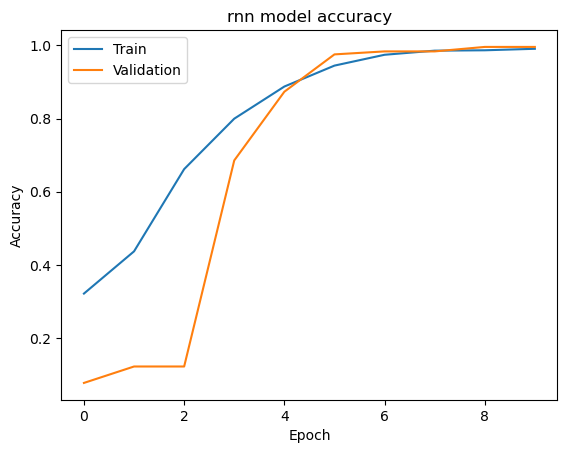

Training cnn model...
Epoch 1/10
31/31 [==============================] - 2s 40ms/step - loss: 0.6223 - accuracy: 0.2880 - val_loss: 0.8200 - val_accuracy: 0.1306
Epoch 2/10
31/31 [==============================] - 1s 30ms/step - loss: 0.5409 - accuracy: 0.3616 - val_loss: 0.7687 - val_accuracy: 0.1061
Epoch 3/10
31/31 [==============================] - 1s 31ms/step - loss: 0.4826 - accuracy: 0.5455 - val_loss: 0.7699 - val_accuracy: 0.1224
Epoch 4/10
31/31 [==============================] - 1s 30ms/step - loss: 0.3680 - accuracy: 0.6946 - val_loss: 0.7606 - val_accuracy: 0.1347
Epoch 5/10
31/31 [==============================] - 1s 31ms/step - loss: 0.2789 - accuracy: 0.7865 - val_loss: 0.6951 - val_accuracy: 0.1347
Epoch 6/10
31/31 [==============================] - 1s 31ms/step - loss: 0.2179 - accuracy: 0.8355 - val_loss: 0.5843 - val_accuracy: 0.1306
Epoch 7/10
31/31 [==============================] - 1s 31ms/step - loss: 0.1781 - accuracy: 0.8560 - val_loss: 0.5413 - val_accuracy

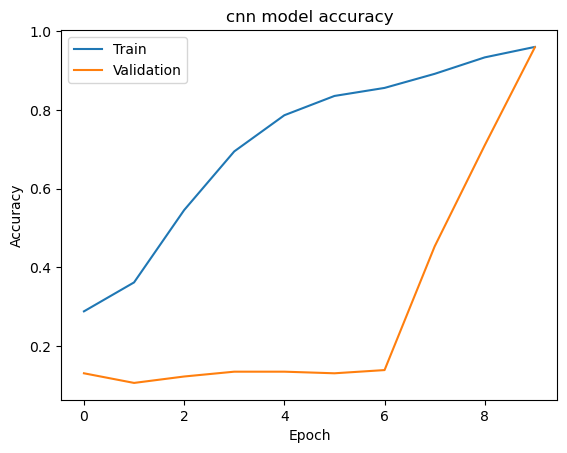

Training lstm model...
Epoch 1/10
31/31 [==============================] - 7s 120ms/step - loss: 0.5977 - accuracy: 0.3075 - val_loss: 0.7365 - val_accuracy: 0.0000e+00
Epoch 2/10
31/31 [==============================] - 3s 91ms/step - loss: 0.5285 - accuracy: 0.3892 - val_loss: 0.7345 - val_accuracy: 0.0000e+00
Epoch 3/10
31/31 [==============================] - 3s 99ms/step - loss: 0.4334 - accuracy: 0.6129 - val_loss: 0.7591 - val_accuracy: 0.1184
Epoch 4/10
31/31 [==============================] - 3s 96ms/step - loss: 0.3268 - accuracy: 0.7324 - val_loss: 0.6514 - val_accuracy: 0.1184
Epoch 5/10
31/31 [==============================] - 3s 94ms/step - loss: 0.2401 - accuracy: 0.8039 - val_loss: 0.5064 - val_accuracy: 0.2286
Epoch 6/10
31/31 [==============================] - 3s 93ms/step - loss: 0.1659 - accuracy: 0.8856 - val_loss: 0.3078 - val_accuracy: 0.7551
Epoch 7/10
31/31 [==============================] - 3s 93ms/step - loss: 0.1199 - accuracy: 0.9356 - val_loss: 0.1355 - va

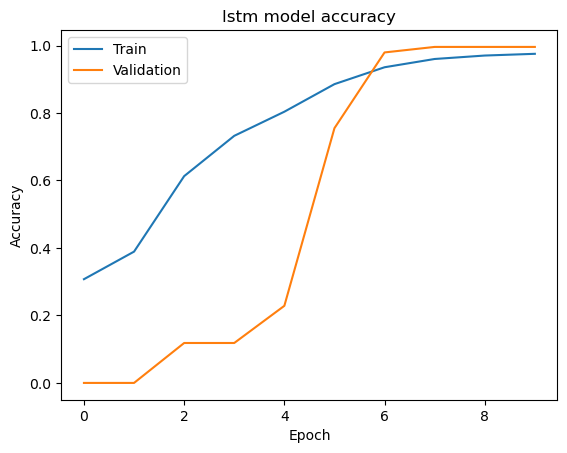

Training bilstm model...
Epoch 1/10
31/31 [==============================] - 10s 167ms/step - loss: 0.5875 - accuracy: 0.3238 - val_loss: 0.7625 - val_accuracy: 0.1388
Epoch 2/10
31/31 [==============================] - 4s 122ms/step - loss: 0.5249 - accuracy: 0.4116 - val_loss: 0.7896 - val_accuracy: 0.0367
Epoch 3/10
31/31 [==============================] - 4s 118ms/step - loss: 0.4186 - accuracy: 0.6568 - val_loss: 0.7499 - val_accuracy: 0.1347
Epoch 4/10
31/31 [==============================] - 4s 120ms/step - loss: 0.3205 - accuracy: 0.7365 - val_loss: 0.7510 - val_accuracy: 0.1265
Epoch 5/10
31/31 [==============================] - 4s 118ms/step - loss: 0.2254 - accuracy: 0.8253 - val_loss: 0.5323 - val_accuracy: 0.4204
Epoch 6/10
31/31 [==============================] - 3s 106ms/step - loss: 0.1479 - accuracy: 0.9009 - val_loss: 0.2128 - val_accuracy: 0.8571
Epoch 7/10
31/31 [==============================] - 3s 105ms/step - loss: 0.1127 - accuracy: 0.9418 - val_loss: 0.1913 - v

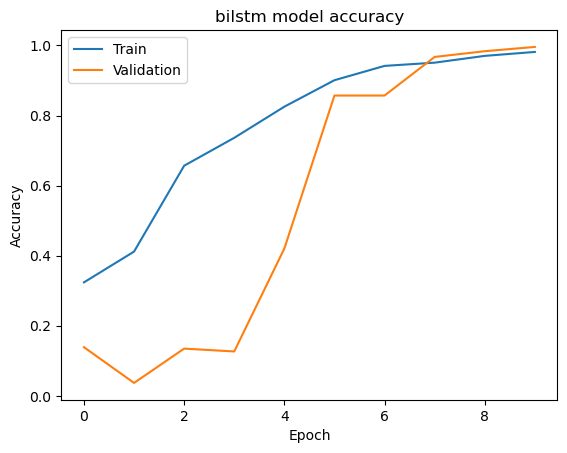

In [7]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [8]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

Training rnn model...
Epoch 1/10
10/10 [==============================] - 2s 100ms/step - loss: 0.6458 - accuracy: 0.2730 - val_loss: 0.7060 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 54ms/step - loss: 0.5523 - accuracy: 0.3289 - val_loss: 0.9187 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 52ms/step - loss: 0.5300 - accuracy: 0.3487 - val_loss: 0.9082 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 54ms/step - loss: 0.5205 - accuracy: 0.3849 - val_loss: 0.8634 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 55ms/step - loss: 0.5055 - accuracy: 0.5033 - val_loss: 0.8761 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 55ms/step - loss: 0.4710 - accuracy: 0.6513 - val_loss: 0.8511 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 55ms/step - loss: 0.4293 - accuracy: 0.7697 - val_lo

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

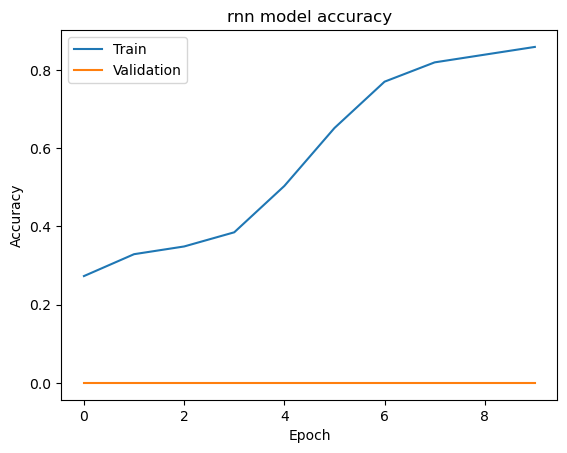

Training cnn model...
Epoch 1/10
10/10 [==============================] - 2s 61ms/step - loss: 0.6744 - accuracy: 0.2895 - val_loss: 0.6522 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 0s 36ms/step - loss: 0.6061 - accuracy: 0.3125 - val_loss: 0.6476 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 0s 36ms/step - loss: 0.5550 - accuracy: 0.3224 - val_loss: 0.7710 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 0s 35ms/step - loss: 0.5380 - accuracy: 0.3487 - val_loss: 0.8249 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 0s 34ms/step - loss: 0.5265 - accuracy: 0.3849 - val_loss: 0.9121 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 0s 34ms/step - loss: 0.5083 - accuracy: 0.5000 - val_loss: 0.9218 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 0s 35ms/step - loss: 0.4961 - accuracy: 0.4737 - val_los

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

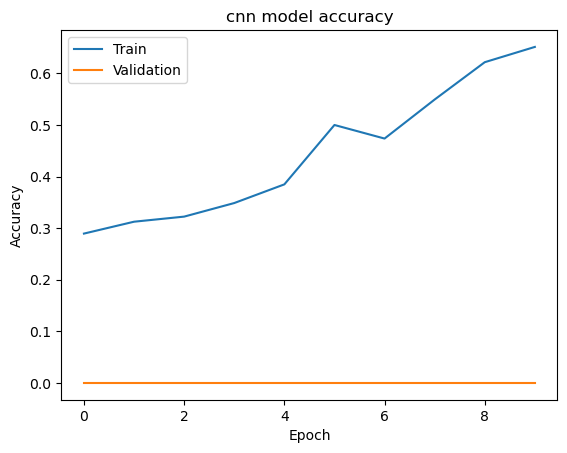

Training lstm model...
Epoch 1/10
10/10 [==============================] - 5s 253ms/step - loss: 0.6752 - accuracy: 0.3191 - val_loss: 0.6946 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 92ms/step - loss: 0.5777 - accuracy: 0.3125 - val_loss: 0.8140 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 92ms/step - loss: 0.5407 - accuracy: 0.3388 - val_loss: 0.9539 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 92ms/step - loss: 0.5362 - accuracy: 0.3421 - val_loss: 0.9483 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 93ms/step - loss: 0.5204 - accuracy: 0.4178 - val_loss: 0.8709 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 95ms/step - loss: 0.5148 - accuracy: 0.4276 - val_loss: 0.9171 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 99ms/step - loss: 0.4823 - accuracy: 0.5691 - val_l

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

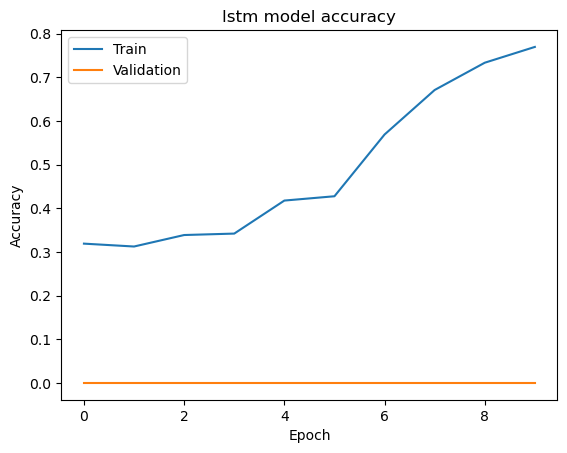

Training bilstm model...
Epoch 1/10
10/10 [==============================] - 7s 231ms/step - loss: 0.6651 - accuracy: 0.3257 - val_loss: 0.6492 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 1s 117ms/step - loss: 0.5749 - accuracy: 0.2895 - val_loss: 0.8566 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 1s 114ms/step - loss: 0.5412 - accuracy: 0.3553 - val_loss: 0.8113 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 1s 115ms/step - loss: 0.5332 - accuracy: 0.3618 - val_loss: 0.8595 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 1s 113ms/step - loss: 0.5000 - accuracy: 0.4803 - val_loss: 0.8044 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 1s 114ms/step - loss: 0.4487 - accuracy: 0.6086 - val_loss: 0.9527 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 1s 109ms/step - loss: 0.4033 - accuracy: 0.6513

/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solomon/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/ashis-solo

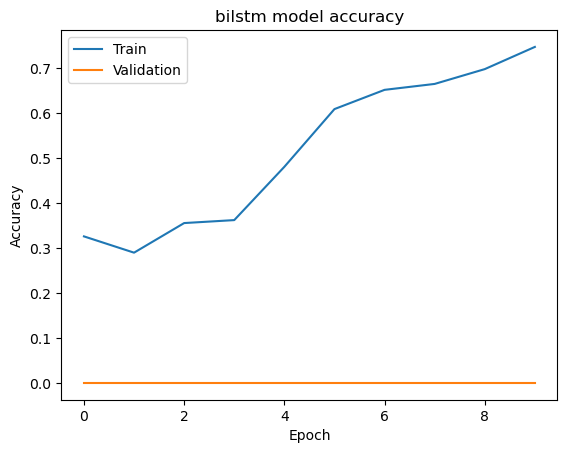

In [9]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# FINDING BEST PARAMS FOR OVERSAMPLED DATA

In [10]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [11]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

rnn_oversampled_best_params = grid_result.best_params_

/tmp/ipykernel_11379/1531335905.py:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
26/26 [==============================] - 3s 67ms/step - loss: 0.5973 - accuracy: 0.3431


39/39 [==============================] - 3s 48ms/step - loss: 0.6103 - accuracy: 0.2704
Best parameters: {'dense_size': 32, 'dropout_rate': 0.2, 'embedding_dim': 50, 'max_seq_length': 100, 'num_words': 50000, 'rnn_units': 32}
Best accuracy: 0.29411765933036804


In [12]:
rnn_oversampled_best_params

{'dense_size': 32,
 'dropout_rate': 0.2,
 'embedding_dim': 50,
 'max_seq_length': 100,
 'num_words': 50000,
 'rnn_units': 32}

# CNN

In [13]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

cnn_oversampled_best_params = grid_result.best_params_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Epoch 1/5


/tmp/ipykernel_56883/3953337257.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


100/100 [==============================] - 3s 24ms/step - loss: 0.5755 - accuracy: 0.3350
Epoch 2/5
100/100 [==============================] - 2s 25ms/step - loss: 0.3320 - accuracy: 0.7220
Epoch 3/5
100/100 [==============================] - 2s 25ms/step - loss: 0.1852 - accuracy: 0.8582
Epoch 4/5
100/100 [==============================] - 2s 25ms/step - loss: 0.1336 - accuracy: 0.9086
Epoch 5/5
50/50 [==============================] - 0s 2ms/step - loss: 0.2349 - accuracy: 0.8229
Epoch 1/5
 86/100 [========================>.....] - ETA: 0s - loss: 0.5814 - accuracy: 0.3779

KeyboardInterrupt: 

In [ ]:
cnn_oversampled_best_params

# LSTM

In [14]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

lstm_oversampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/3755137833.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:02:22.527440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:22.528493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:02:22.734416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:22.735546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:02:22.736619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

100/100 [==============================] - 6s 46ms/step - loss: 0.5340 - accuracy: 0.4286
Epoch 2/5
 28/100 [=======>......................] - ETA: 3s - loss: 0.2951 - accuracy: 0.7478

KeyboardInterrupt: 

In [ ]:
lstm_oversampled_best_params

# BILSTM

In [15]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

bilstm_oversampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/1400334571.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:02:33.234542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:33.235626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/conc

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:02:33.634064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 02:02:33.669091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:02:33.670470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

100/100 [==============================] - 8s 55ms/step - loss: 0.5448 - accuracy: 0.3961
Epoch 2/5
 45/100 [============>.................] - ETA: 2s - loss: 0.2959 - accuracy: 0.7486

KeyboardInterrupt: 

In [ ]:
bilstm_oversampled_best_params

# FINDING BEST PARAMS FOR UNDERSAMPLED DATA

In [16]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# RNN

In [17]:
# Define the parameter grid to search over
param_grid = {
    'num_words': [20000, 50000],
    'embedding_dim': [50, 100],
    'rnn_units': [32, 64],
    'dense_size': [32, 64],
    'dropout_rate': [0.2,0.3],
    'max_seq_length': [100],
}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

rnn_undersampled_best_params = grid_result.best_params_

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


/tmp/ipykernel_56883/1669981765.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_rnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 2s 26ms/step - loss: 0.6074 - accuracy: 0.3680
Epoch 2/5
32/32 [==============================] - 1s 27ms/step - loss: 0.5117 - accuracy: 0.3940
Epoch 3/5
32/32 [==============================] - 1s 28ms/step - loss: 0.4837 - accuracy: 0.4590
Epoch 4/5
32/32 [==============================] - 1s 26ms/step - loss: 0.4385 - accuracy: 0.6290
Epoch 5/5
16/16 [==============================] - 0s 4ms/step - loss: 0.9784 - accuracy: 0.1480
Epoch 1/5
32/32 [==============================] - 2s 27ms/step - loss: 0.5978 - accuracy: 0.3420
Epoch 2/5
32/32 [==============================] - 1s 26ms/step - loss: 0.5156 - accuracy: 0.4590
Epoch 3/5
32/32 [==============================] - 1s 26ms/step - loss: 0.4503 - accuracy: 0.6440
Epoch 4/5
32/32 [==============================] - 1s 28ms/step - loss: 0.3608 - accuracy: 0.7150
Epoch 5/5
16/16 [==============================] - 0s 5ms/step - loss: 0.7413 - accuracy: 0.0360
Epoch 1/5
32/32 [===============

KeyboardInterrupt: 

In [ ]:
rnn_undersampled_best_params

# CNN

In [18]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000, 50000],
              'embedding_size': [64, 128],
              'filter_size': [32, 64],
              'kernel_size': [3, 5],
              'pool_size': [2, 3],
              'dense_size': [64, 128],
              'dropout_rate': [0.2, 0.3]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

cnn_undersampled_best_params = grid_result.best_params_

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Epoch 1/5


/tmp/ipykernel_56883/3953337257.py:19: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, epochs=epochs, batch_size=batch_size)


32/32 [==============================] - 1s 24ms/step - loss: 0.5964 - accuracy: 0.3710
Epoch 2/5
32/32 [==============================] - 1s 29ms/step - loss: 0.4849 - accuracy: 0.3800
Epoch 3/5
32/32 [==============================] - 1s 25ms/step - loss: 0.4667 - accuracy: 0.4600
Epoch 4/5
32/32 [==============================] - 1s 25ms/step - loss: 0.3643 - accuracy: 0.6810
Epoch 5/5
16/16 [==============================] - 0s 2ms/step - loss: 1.5430 - accuracy: 0.1440
Epoch 1/5
32/32 [==============================] - 1s 25ms/step - loss: 0.6166 - accuracy: 0.3550
Epoch 2/5
32/32 [==============================] - 1s 26ms/step - loss: 0.5277 - accuracy: 0.3960
Epoch 3/5
32/32 [==============================] - 1s 29ms/step - loss: 0.4999 - accuracy: 0.5270
Epoch 4/5
 1/32 [..............................] - ETA: 1s - loss: 0.4833 - accuracy: 0.5938

KeyboardInterrupt: 

In [ ]:
cnn_undersampled_best_params

# LSTM

In [19]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

lstm_undersampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/3755137833.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_lstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:03:23.153656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:23.154652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:03:23.374432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:23.375822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:03:23.376940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

32/32 [==============================] - 3s 44ms/step - loss: 0.5801 - accuracy: 0.3580
Epoch 2/5
32/32 [==============================] - 1s 44ms/step - loss: 0.4797 - accuracy: 0.3770
Epoch 3/5
26/32 [=======================>......] - ETA: 0s - loss: 0.4745 - accuracy: 0.4062

KeyboardInterrupt: 

In [ ]:
lstm_undersampled_best_params

# BILSTM

In [20]:
# Define the parameter grid to search over

param_grid = {'num_words': [20000,50000],
              'lstm_size': [64,128],
              'embedding_size':[64,128],
              'dropout_rate': [0.2,0.3],
              'dense_size': [64,128]}

# Define epochs and batch size
epochs = 5
batch_size = 32

# Define input shape


# Create the KerasClassifier object
model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=1)

# Fit the GridSearchCV object to the data
grid_result = grid.fit(X_train_resampled, y_train_resampled_cat, callbacks=[EarlyStopping(monitor='loss', patience=2, min_delta=0.0001)])

# Print the best parameters and accuracy score
print(f"Best parameters: {grid_result.best_params_}")
print(f"Best accuracy: {grid_result.best_score_}")

bilstm_undersampled_best_params = grid_result.best_params_

/tmp/ipykernel_56883/1400334571.py:17: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_bilstm, epochs=epochs, batch_size=batch_size)
2023-03-30 02:03:31.934131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:31.935133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/conc

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/5


2023-03-30 02:03:32.044426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 02:03:32.078900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:03:32.079896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

32/32 [==============================] - 4s 56ms/step - loss: 0.5523 - accuracy: 0.3580
Epoch 2/5
32/32 [==============================] - 2s 50ms/step - loss: 0.4799 - accuracy: 0.3970
Epoch 3/5
32/32 [==============================] - 2s 54ms/step - loss: 0.4508 - accuracy: 0.4950
Epoch 4/5
 9/32 [=======>......................] - ETA: 1s - loss: 0.3972 - accuracy: 0.6389

KeyboardInterrupt: 

In [ ]:
bilstm_undersampled_best_params

# OVERSAMPLING DATASET AND ENCODING Y LABELS

In [6]:
#oversampling
ros = RandomOverSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (OVERSAMPLED)

In [7]:
# def create_rnn(num_words=rnn_oversampled_best_params['num_words'],\
#                embedding_dim=rnn_oversampled_best_params['embedding_dim'],\
#                rnn_units=rnn_oversampled_best_params['rnn_units'],\
#                dense_size=rnn_oversampled_best_params['dense_size'],\
#                dropout_rate=rnn_oversampled_best_params['dropout_rate'],\
#                max_seq_length=rnn_oversampled_best_params['max_seq_length']):
#     rnn_model = Sequential([
#         Embedding(num_words, embedding_dim, input_length=max_seq_length),
#         SimpleRNN(units=rnn_units, return_sequences=False),
#         Dense(dense_size, activation='relu'),
#         Dropout(dropout_rate),
#         Dense(4, activation='softmax')
#     ])
#     rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#     return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=64, kernel_size=5, pool_size=2, dense_size=128, dropout_rate=0.2):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# RUNNING MODELS ON OVERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 23:27:05.536927: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-30 23:27:05.536978: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-30 23:27:05.537013: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu): /proc/driver/nvidia/version does not exist
2023-03-30 23:27:05.537449: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Training cnn model...
Epoch 1/10
383/383 [==============================] - 27s 66ms/step - loss: 0.3284 - accuracy: 0.6897 - val_loss: 0.1185 - val_accuracy: 0.9086
Epoch 2/10
383/383 [==============================] - 25s 65ms/step - loss: 0.1302 - accuracy: 0.9039 - val_loss: 0.0957 - val_accuracy: 0.9367
Epoch 3/10
383/383 [==============================] - 26s 67ms/step - loss: 0.0898 - accuracy: 0.9360 - val_loss: 0.0571 - val_accuracy: 0.9634
Epoch 4/10
383/383 [==============================] - 26s 68ms/step - loss: 0.0682 - accuracy: 0.9519 - val_loss: 0.0435 - val_accuracy: 0.9644
Epoch 5/10
383/383 [==============================] - 26s 68ms/step - loss: 0.0517 - accuracy: 0.9645 - val_loss: 0.0187 - val_accuracy: 0.9886
Epoch 6/10
383/383 [==============================] - 26s 69ms/step - loss: 0.0392 - accuracy: 0.9729 - val_loss: 0.0138 - val_accuracy: 0.9935
Epoch 7/10
383/383 [==============================] - 26s 67ms/step - loss: 0.0307 - accuracy: 0.9803 - val_loss: 

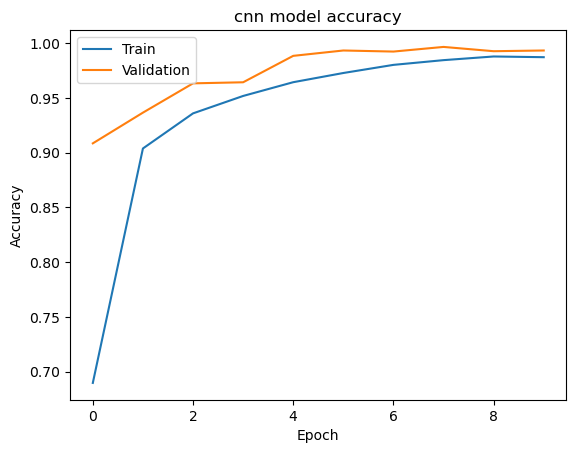

In [8]:
# Compile the models
models = {
#     'rnn': create_rnn(),
    'cnn': create_cnn()
#     'lstm': create_lstm(),
#     'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# UNDERSAMPLING DATASET AND ENCODING Y LABELS

In [6]:
#undersampling
ros = RandomUnderSampler()
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_seq_padded, y_train)






#encoding y labels
y_train_resampled = pd.Categorical(y_train_resampled)
y_train_resampled = y_train_resampled.codes
y_train_resampled_cat = pd.get_dummies(y_train_resampled).values
y_test = pd.Categorical(y_test)
y_test = y_test.codes
y_test_cat = pd.get_dummies(y_test).values

# DEFINE THE NEURAL NETWORK MODELS WITH BEST PARAMS PASSED (UNDERSAMPLED)

In [7]:
def create_rnn(num_words=20000, embedding_dim=100, rnn_units=64, dense_size=64, dropout_rate=0.3, max_seq_length=100):
    rnn_model = Sequential([
        Embedding(num_words, embedding_dim, input_length=max_seq_length),
        SimpleRNN(units=rnn_units, return_sequences=False),
        Dense(dense_size, activation='relu'),
        Dropout(dropout_rate),
        Dense(4, activation='softmax')
    ])
    rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return rnn_model

def create_cnn(num_words=50000, embedding_size=128, filter_size=32, kernel_size=5, pool_size=3, dense_size=128, dropout_rate=0.3):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Conv1D(filters=filter_size, kernel_size=kernel_size, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def create_lstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.3, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(LSTM(lstm_size))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model



def create_bilstm(num_words=50000, lstm_size=128, embedding_size=128, dropout_rate=0.2, dense_size=64):
    model = Sequential()
    model.add(Embedding(num_words, embedding_size, input_length=100))
    model.add(Bidirectional(LSTM(lstm_size)))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# RUNNING MODELS ON UNDERSAMPLED DATASET AND PERFORMANCE ANALYSIS

2023-03-30 02:09:52.349957: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-03-30 02:09:52.710833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:09:52.712961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:09:52.714029: I tensorflow/core/com

Training rnn model...
Epoch 1/10


2023-03-30 02:09:53.009338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis' with dtype int32 and shape [1]
	 [[{{node gradients/ReverseV2_grad/ReverseV2/ReverseV2/axis}}]]
2023-03-30 02:09:53.045059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:09:53.046254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message):

38/38 [==============================] - 3s 45ms/step - loss: 0.5528 - accuracy: 0.3300 - val_loss: 0.9157 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 2s 41ms/step - loss: 0.4693 - accuracy: 0.5617 - val_loss: 0.9151 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 1s 39ms/step - loss: 0.3532 - accuracy: 0.7300 - val_loss: 0.9299 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 2s 39ms/step - loss: 0.2405 - accuracy: 0.8242 - val_loss: 0.8638 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 2s 41ms/step - loss: 0.1576 - accuracy: 0.8908 - val_loss: 0.7701 - val_accuracy: 0.2433
Epoch 6/10
38/38 [==============================] - 2s 40ms/step - loss: 0.1030 - accuracy: 0.9375 - val_loss: 0.7610 - val_accuracy: 0.3333
Epoch 7/10
38/38 [==============================] - 2s 41ms/step - loss: 0.0694 - accuracy: 0.9617 - val_loss: 0.7098 - val_accuracy: 0.4700
Epoch 8/

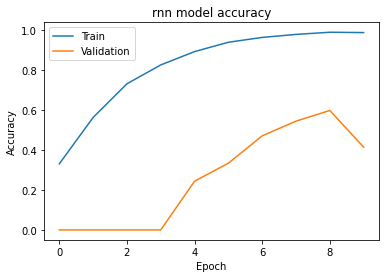

Training cnn model...
Epoch 1/10
38/38 [==============================] - 5s 112ms/step - loss: 0.5757 - accuracy: 0.3133 - val_loss: 1.0047 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 4s 110ms/step - loss: 0.5301 - accuracy: 0.3300 - val_loss: 0.9589 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 4s 109ms/step - loss: 0.4894 - accuracy: 0.4875 - val_loss: 0.9625 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 4s 110ms/step - loss: 0.3797 - accuracy: 0.6775 - val_loss: 0.8861 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 4s 107ms/step - loss: 0.3039 - accuracy: 0.7742 - val_loss: 0.9231 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 4s 108ms/step - loss: 0.2422 - accuracy: 0.8175 - val_loss: 0.8968 - val_accuracy: 0.0000e+00
Epoch 7/10
38/38 [==============================] - 4s 109ms/step - loss: 0.1955 - accuracy: 0.8483 - 

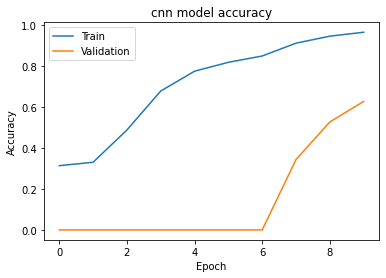

Training lstm model...
Epoch 1/10


2023-03-30 02:10:52.591102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:10:52.592797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:10:52.594044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5727 - accuracy: 0.3250

2023-03-30 02:10:59.225654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:10:59.226732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:10:59.227657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 7s 151ms/step - loss: 0.5727 - accuracy: 0.3250 - val_loss: 0.9039 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 6s 146ms/step - loss: 0.5071 - accuracy: 0.4525 - val_loss: 0.9121 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 6s 146ms/step - loss: 0.3992 - accuracy: 0.6300 - val_loss: 0.9440 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 6s 145ms/step - loss: 0.3087 - accuracy: 0.7708 - val_loss: 0.8779 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 5s 144ms/step - loss: 0.2416 - accuracy: 0.8217 - val_loss: 0.9292 - val_accuracy: 0.0000e+00
Epoch 6/10
38/38 [==============================] - 6s 146ms/step - loss: 0.1858 - accuracy: 0.8708 - val_loss: 0.6312 - val_accuracy: 0.4100
Epoch 7/10
38/38 [==============================] - 6s 149ms/step - loss: 0.1298 - accuracy: 0.9225 - val_loss: 0.5192 - val_accuracy: 0.64

2023-03-30 02:11:49.706743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:11:49.708296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:11:49.710000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 1s 19ms/step
lstm model confusion matrix:
[[127   1  11   0]
 [ 19 197  32   1]
 [ 27  43 229   3]
 [ 11   8  11  80]]
lstm model classification report:
              precision    recall  f1-score   support

           0       0.69      0.91      0.79       139
           1       0.79      0.79      0.79       249
           2       0.81      0.76      0.78       302
           3       0.95      0.73      0.82       110

    accuracy                           0.79       800
   macro avg       0.81      0.80      0.80       800
weighted avg       0.80      0.79      0.79       800

lstm model accuracy: 0.7913
lstm model precision: 0.8107
lstm model recall: 0.7976


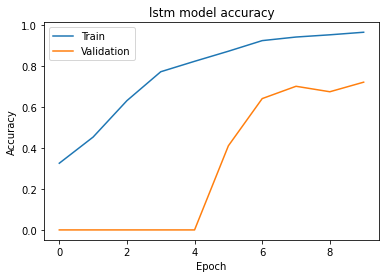

Training bilstm model...
Epoch 1/10


2023-03-30 02:11:50.609918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:11:50.611464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:11:50.612791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - ETA: 0s - loss: 0.5563 - accuracy: 0.3333

2023-03-30 02:12:00.027978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:12:00.029160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:12:00.030345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

38/38 [==============================] - 10s 207ms/step - loss: 0.5563 - accuracy: 0.3333 - val_loss: 1.0141 - val_accuracy: 0.0000e+00
Epoch 2/10
38/38 [==============================] - 8s 200ms/step - loss: 0.4632 - accuracy: 0.5375 - val_loss: 0.9329 - val_accuracy: 0.0000e+00
Epoch 3/10
38/38 [==============================] - 8s 208ms/step - loss: 0.3510 - accuracy: 0.7167 - val_loss: 0.8705 - val_accuracy: 0.0000e+00
Epoch 4/10
38/38 [==============================] - 8s 213ms/step - loss: 0.2543 - accuracy: 0.7833 - val_loss: 0.8724 - val_accuracy: 0.0000e+00
Epoch 5/10
38/38 [==============================] - 7s 191ms/step - loss: 0.1837 - accuracy: 0.8642 - val_loss: 0.7537 - val_accuracy: 0.1900
Epoch 6/10
38/38 [==============================] - 7s 191ms/step - loss: 0.1248 - accuracy: 0.9150 - val_loss: 0.7662 - val_accuracy: 0.4067
Epoch 7/10
38/38 [==============================] - 7s 193ms/step - loss: 0.0969 - accuracy: 0.9417 - val_loss: 0.5685 - val_accuracy: 0.6100


2023-03-30 02:13:08.333300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-03-30 02:13:08.335886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-03-30 02:13:08.337074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

25/25 [==============================] - 1s 24ms/step
bilstm model confusion matrix:
[[121   8   8   2]
 [ 14 207  25   3]
 [ 22  51 228   1]
 [ 13   7  10  80]]
bilstm model classification report:
              precision    recall  f1-score   support

           0       0.71      0.87      0.78       139
           1       0.76      0.83      0.79       249
           2       0.84      0.75      0.80       302
           3       0.93      0.73      0.82       110

    accuracy                           0.80       800
   macro avg       0.81      0.80      0.80       800
weighted avg       0.81      0.80      0.80       800

bilstm model accuracy: 0.7950
bilstm model precision: 0.8104
bilstm model recall: 0.7960


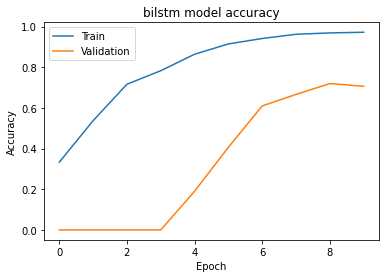

In [8]:
# Compile the models
models = {
    'rnn': create_rnn(),
    'cnn': create_cnn(),
    'lstm': create_lstm(),
    'bilstm': create_bilstm()
}


# Define a callback to save the model with the best validation accuracy
best_model = ModelCheckpoint('best_model.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy', mode='max')

# Train the models
epochs = 10
batch_size = 32


for name, model in models.items():
    print(f'Training {name} model...')
    history = model.fit(X_train_resampled, y_train_resampled_cat, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[best_model])
    y_pred = model.predict(X_test_seq_padded)
    y_pred = np.argmax(y_pred, axis=1)
    cm = confusion_matrix(y_test, y_pred)
    print(f'{name} model confusion matrix:')
    print(cm)
    print(f'{name} model classification report:')
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    print(f'{name} model accuracy: {accuracy:.4f}')
    print(f'{name} model precision: {precision:.4f}')
    print(f'{name} model recall: {recall:.4f}')
    
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{name} model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()